In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#Available Timeslots:
#time_slots = ["10 AM", "11 AM", "12 PM", "1 PM", "2 PM", "3 PM"]

#24 Hour Clock
time_slots = [10,11,12,13,14,15]

In [4]:
#Facilitators:
facilitators = ["Lock", "Glen", "Banks", "Richards", "Shaw","Singer", "Uther", "Tyler", "Numen", "Zeldin"]

In [5]:
#Number of activities:
activities = ["SLA100A", "SLA100B", "SLA191A", "SLA191B","SLA201", "SLA291", "SLA303", "SLA304","SLA394", "SLA449", "SLA451"]

In [6]:
#Facilitator Preference:
other_facilitators = {
    "SLA100A": ["Numen","Richards"],
    "SLA100B": ["Numen","Richards"],
    "SLA191A": ["Numen","Richards"],
    "SLA191B": ["Numen","Richards"],
    "SLA201": ["Numen", "Richards","Singer"],
    "SLA291": ["Numen","Richards","Shaw","Tyler"],
    "SLA303": ["Numen", "Singer","Shaw"],
    "SLA304": ["Numen", "Singer","Shaw","Richards","Uther","Zeldin"],
    "SLA394" : ["Richards", "Zeldin"],
    "SLA449" : ["Zeldin", "Uther"],
    "SLA451" : ["Zeldin", "Uther", "Richards", "Banks"]
}
                                   
preferred_facilitators = {
    "SLA100A": ["Glen", "Lock", "Banks", "Zeldin"], 
    "SLA100B": ["Glen", "Lock", "Banks", "Zeldin"], 
    "SLA191A": ["Glen", "Lock", "Banks", "Zeldin"], 
    "SLA191B": ["Glen", "Lock", "Banks", "Zeldin"], 
    "SLA201": ["Glen", "Banks", "Zeldin", "Shaw"], 
    "SLA291": ["Lock", "Banks", "Zeldin", "Singer"], 
    "SLA303": ["Glen", "Zeldin", "Banks"], 
    "SLA304": ["Glen", "Banks", "Tyler"], 
    "SLA394": ["Tyler", "Singer"], 
    "SLA449": ["Tyler", "Singer", "Shaw"], 
    "SLA451": ["Tyler", "Singer", "Shaw"]
}

In [7]:
#Expected Enrollments:
expected_enrollment = { 
    "SLA100A": 50, 
    "SLA100B": 50, 
    "SLA191A": 50, 
    "SLA191B": 50, 
    "SLA201": 50, 
    "SLA291": 50, 
    "SLA303": 60, 
    "SLA304": 25, 
    "SLA394": 20, 
    "SLA449": 60, 
    "SLA451": 100
}

In [8]:
#Room Capacity:
rooms = {"Slater 003": 45, 
         "Roman 216": 30, 
         "Loft 206": 75,
         "Roman 201": 50, 
         "Loft 310": 108, 
         "Beach 201": 60, 
         "Beach 301": 75, 
         "Logos 325": 450, 
         "Frank 119": 60
}

In [ ]:
class ActivityAssignment:
    def __init__(self, activity, room, time, facilitator):
        self.activity = activity
        self.room = room
        self.time = time
        self.facilitator = facilitator

In [21]:
class Schedule:
    def __init__(self, activities, rooms, time_slots, facilitators):
        self.activities = activities
        self.rooms = rooms
        self.time_slots = time_slots
        self.facilitators = facilitators
        self.assignments = []
        self.fitness = 0.0

    def generate_random(self):
        for activity in activities:
            room = random.choice(list(rooms.keys()))
            time = random.choice(time_slots)
            facilitator = random.choice(facilitators)
            assignment = ActivityAssignment(activity, room, time, facilitator)
            self.assignments.append(assignment)
    
    def calculate_fitness(self):
        #print("Facilitators:", facilitators)  # Should show the list of facilitator names
        #print("Time Slots:", time_slots)
        self.fitness = 0
        facilitator_count = {fac: 0 for fac in facilitators}
        facilitator_time_count = {(fac, time): 0 for fac in facilitators for time in time_slots}
        facilitator_time_activities = {(fac, time): [] for fac in facilitators for time in time_slots}
        activities_at_time = {time: [] for time in time_slots}

        for assignment in self.assignments:
            facilitator_count[assignment.facilitator] += 1
            facilitator_time_count[(assignment.facilitator, assignment.time)] += 1
            facilitator_time_activities[(assignment.facilitator, assignment.time)].append(assignment.activity)
            activities_at_time[assignment.time].append(assignment)

        for time, assignments in activities_at_time.items():
            room_activity_count = {}
            for assignment in assignments:
                # Check for room-time conflicts
                key = (assignment.time, assignment.room)
                if key not in room_activity_count:
                    room_activity_count[key] = 0
                room_activity_count[key] += 1

                # Room capacity checks
                room_capacity = rooms[assignment.room]
                expected = expected_enrollment[assignment.activity]

                if room_capacity < expected:
                    self.fitness -= 0.5
                elif room_capacity > 3 * expected:
                    self.fitness -= 0.2
                elif room_capacity > 6 * expected:
                    self.fitness -= 0.4
                else:
                    self.fitness += 0.3

                # Facilitator preferences
                if assignment.facilitator in preferred_facilitators.get(assignment.activity, []):
                    self.fitness += 0.5
                elif assignment.facilitator in other_facilitators.get(assignment.activity, []):
                    self.fitness += 0.2
                else:
                    self.fitness -= 0.1

            for (t, r), count in room_activity_count.items():
                if count > 1:
                    self.fitness -= 0.5 * (count - 1)  # Penalize for each extra assignment in the same slot

        # Facilitator load penalties
        for fac, count in facilitator_count.items():
            if fac == "Tyler" and count < 2:
                continue  # No penalty for Dr. Tyler if overseeing fewer than 2 activities
            if count == 1 or count == 2:
                self.fitness -= 0.4
            if count > 4:
                self.fitness -= 0.5

        # Penalties for facilitators scheduled in consecutive time slots
        for fac in facilitators:
            for time in time_slots:
                if time + 1 in time_slots and facilitator_time_count[(fac, time)] > 0 and facilitator_time_count[(fac, time + 1)] > 0:
                    self.fitness -= 0.2  # General penalty for consecutive slots
                    activities1 = facilitator_time_activities[(fac, time)]
                    activities2 = facilitator_time_activities[(fac, time + 1)]
                    # Check specific rules for activity pairs across locations
                    if any(a in activities1 for a in ["SLA191A", "SLA191B"]) and any(b in activities2 for b in ["SLA100A", "SLA100B"]):
                        self.fitness += 0.5  # Consecutive SLA 191 and SLA 101

        self.apply_specific_course_rules()

    def apply_specific_course_rules(self):
        activity_times = {'SLA101A': None, 'SLA101B': None, 'SLA191A': None, 'SLA191B': None}
        activity_locations = {'SLA101A': None, 'SLA101B': None, 'SLA191A': None, 'SLA191B': None}

        # Gather data about SLA 101 and SLA 191 activities
        for assignment in self.assignments:
            if assignment.activity in activity_times:
                activity_times[assignment.activity] = assignment.time
                activity_locations[assignment.activity] = assignment.room

        # Check conditions for the two sections of SLA 101
        if activity_times['SLA101A'] is not None and activity_times['SLA101B'] is not None:
            if activity_times['SLA101A'] == activity_times['SLA101B']:
                self.fitness -= 0.5
            elif abs(activity_times['SLA101A'] - activity_times['SLA101B']) > 4:
                self.fitness += 0.5

        # Check conditions for the two sections of SLA 191
        if activity_times['SLA191A'] is not None and activity_times['SLA191B'] is not None:
            if activity_times['SLA191A'] == activity_times['SLA191B']:
                self.fitness -= 0.5
            elif abs(activity_times['SLA191A'] - activity_times['SLA191B']) > 4:
                self.fitness += 0.5

        # Check for SLA 191 and SLA 101 in consecutive time slots or same slot
        sla_191 = ['SLA191A', 'SLA191B']
        sla_101 = ['SLA101A', 'SLA101B']
        for a191 in sla_191:
            for a101 in sla_101:
                if activity_times[a191] and activity_times[a101]:
                    if abs(activity_times[a191] - activity_times[a101]) == 1:
                        self.fitness += 0.5
                        if (activity_locations[a191] in ['Roman', 'Beach']) != (activity_locations[a101] in ['Roman', 'Beach']):
                            self.fitness -= 0.4
                    elif activity_times[a191] == activity_times[a101]:
                        self.fitness -= 0.25
                    elif abs(activity_times[a191] - activity_times[a101]) == 2:
                        self.fitness += 0.25

    def __str__(self):
        # Building the detailed schedule string
        schedule_details = []
        for assignment in self.assignments:
            details = f"Activity: {assignment.activity}, Room: {assignment.room}, Time(24HR-Clock): {assignment.time}, Facilitator: {assignment.facilitator}"
            schedule_details.append(details)
        schedule_str = "\n".join(schedule_details)
        return f"Schedule Fitness: {self.fitness:.2f}\nSchedule Details:\n{schedule_str}"

#Testing
# Create a schedule instance, generate a random setup, and calculate fitness
schedule = Schedule(activities,rooms,time_slots,facilitators)
schedule.generate_random()
schedule.calculate_fitness()
print(schedule)

Schedule Fitness: 0.60
Schedule Details:
Activity: SLA100A, Room: Loft 206, Time(24HR-Clock): 11, Facilitator: Lock
Activity: SLA100B, Room: Frank 119, Time(24HR-Clock): 13, Facilitator: Glen
Activity: SLA191A, Room: Beach 201, Time(24HR-Clock): 11, Facilitator: Lock
Activity: SLA191B, Room: Logos 325, Time(24HR-Clock): 12, Facilitator: Singer
Activity: SLA201, Room: Beach 201, Time(24HR-Clock): 13, Facilitator: Banks
Activity: SLA291, Room: Roman 201, Time(24HR-Clock): 15, Facilitator: Numen
Activity: SLA303, Room: Loft 310, Time(24HR-Clock): 13, Facilitator: Tyler
Activity: SLA304, Room: Logos 325, Time(24HR-Clock): 14, Facilitator: Numen
Activity: SLA394, Room: Frank 119, Time(24HR-Clock): 10, Facilitator: Richards
Activity: SLA449, Room: Roman 216, Time(24HR-Clock): 15, Facilitator: Tyler
Activity: SLA451, Room: Beach 201, Time(24HR-Clock): 14, Facilitator: Banks


In [23]:
class Population:
    def __init__(self, population_size, activities, rooms, time_slots, facilitators, mutation_rate):
        self.population_size = population_size
        self.activities = activities
        self.rooms = rooms
        self.time_slots = time_slots
        self.facilitators = facilitators
        self.mutation_rate = mutation_rate
        self.schedules = []
        self.fitness_scores = []
        
    def __str__(self):
        avg_fitness = sum(self.fitness_scores) / len(self.fitness_scores) if self.fitness_scores else 0
        best_fitness = max(self.fitness_scores) if self.fitness_scores else 0
        return f"Population of {len(self.schedules)} schedules - Avg Fitness: {avg_fitness:.2f}, Best Fitness: {best_fitness:.2f}"


    def initialize_population(self):
        for _ in range(self.population_size):
            new_schedule = Schedule(self.activities, self.rooms, self.time_slots, self.facilitators)
            new_schedule.generate_random()
            new_schedule.calculate_fitness()
            self.schedules.append(new_schedule)
            self.fitness_scores.append(new_schedule.fitness)
            
    def softmax(self, x):
        #Compute softmax values for each set of scores in x.
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()

    def select_parents(self):
        # Using softmax for probability selection based on fitness
        probabilities = self.softmax(np.array(self.fitness_scores))
        parents = np.random.choice(self.schedules, size=2, p=probabilities, replace=False)
        return parents


    def crossover(self, parent1, parent2):
        # Single-point crossover
        crossover_point = random.randint(1, len(self.activities) - 1)
        child1_assignments = parent1.assignments[:crossover_point] + parent2.assignments[crossover_point:]
        child2_assignments = parent2.assignments[:crossover_point] + parent1.assignments[crossover_point:]
        child1 = Schedule(self.activities, self.rooms, self.time_slots, self.facilitators)
        child2 = Schedule(self.activities, self.rooms, self.time_slots, self.facilitators)
        child1.assignments = child1_assignments
        child2.assignments = child2_assignments
        child1.calculate_fitness()
        child2.calculate_fitness()
        return child1, child2

    def mutate(self, schedule):
    # Targeted mutation - modify attributes with a likelihood to improve fitness
        mutation_probability = 0.1
        for assignment in schedule.assignments:
            if random.random() < mutation_probability:
                swap_idx = random.randint(0, len(schedule.assignments) - 1)
                # Swap times
                assignment.time, schedule.assignments[swap_idx].time = schedule.assignments[swap_idx].time, assignment.time
                # Recalculate fitness after mutation
                schedule.calculate_fitness()

    def run_generation(self):
        new_schedules = []
        while len(new_schedules) < self.population_size:
            parent1, parent2 = self.select_parents()
            child1, child2 = self.crossover(parent1, parent2)
            self.mutate(child1)
            self.mutate(child2)
            new_schedules.extend([child1, child2])
        self.schedules = new_schedules
        self.fitness_scores = [schedule.fitness for schedule in self.schedules]
    
    def get_current_best(self):
        # Find the index of the highest fitness score
        max_index = self.fitness_scores.index(max(self.fitness_scores))
        # Return the schedule and its fitness score at this index
        return self.schedules[max_index], self.fitness_scores[max_index]


#TESTING

population_size = 50
population = Population(population_size, activities, rooms, time_slots, facilitators, 0.01)
population.initialize_population()
for _ in range(5):  # Run for 5 generation
    population.run_generation()
    print(population)


Population of 50 schedules - Avg Fitness: 1.07, Best Fitness: 3.30
Population of 50 schedules - Avg Fitness: 2.27, Best Fitness: 4.50
Population of 50 schedules - Avg Fitness: 3.22, Best Fitness: 5.10
Population of 50 schedules - Avg Fitness: 3.55, Best Fitness: 5.70
Population of 50 schedules - Avg Fitness: 3.69, Best Fitness: 5.60



Generation 1
Population of 500 schedules - Avg Fitness: 1.32, Best Fitness: 5.50

Generation 2
Population of 500 schedules - Avg Fitness: 2.93, Best Fitness: 6.20

Generation 3
Population of 500 schedules - Avg Fitness: 3.82, Best Fitness: 7.10

Generation 4
Population of 500 schedules - Avg Fitness: 4.78, Best Fitness: 7.30

Generation 5
Population of 500 schedules - Avg Fitness: 5.26, Best Fitness: 7.80

Generation 6
Population of 500 schedules - Avg Fitness: 5.66, Best Fitness: 8.00

Generation 7
Population of 500 schedules - Avg Fitness: 5.96, Best Fitness: 7.70

Generation 8
Population of 500 schedules - Avg Fitness: 5.95, Best Fitness: 7.80

Generation 9
Population of 500 schedules - Avg Fitness: 6.15, Best Fitness: 7.80

Generation 10
Population of 500 schedules - Avg Fitness: 6.23, Best Fitness: 8.20

Generation 11
Population of 500 schedules - Avg Fitness: 6.51, Best Fitness: 8.00

Generation 12
Population of 500 schedules - Avg Fitness: 6.56, Best Fitness: 8.20

Generation 1

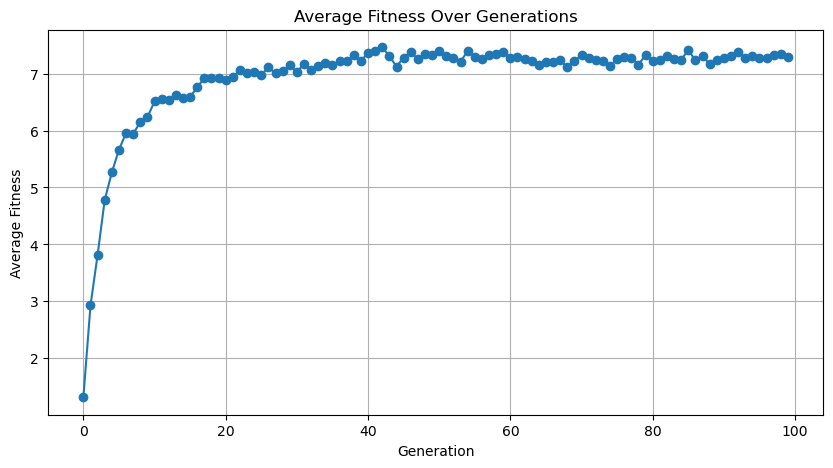

In [24]:
class GeneticAlgorithm:
    def __init__(self, population_size, activities, rooms, time_slots, facilitators, generations):
        self.population_size = population_size
        self.activities = activities
        self.rooms = rooms
        self.time_slots = time_slots
        self.facilitators = facilitators
        self.generations = generations
        
        #Mutation Rate
        self.initial_mutation_rate = 0.1
        self.fitness_history = []
        

    def run(self):
        mutation_rate = self.initial_mutation_rate
        population = Population(self.population_size, self.activities, self.rooms, self.time_slots, self.facilitators, mutation_rate)
        population.initialize_population()

        generation = 0
        while generation < self.generations:
            generation += 1
            print(f"\nGeneration {generation}")
            population.run_generation()
            avg_fitness = sum(population.fitness_scores) / len(population.fitness_scores)
            self.fitness_history.append(avg_fitness)
            print(population)

            
            if generation % 20 == 0 and generation >= 100:  # Adjust every 20 generations, starting from 100
                if (self.fitness_history[-1] - self.fitness_history[-21]) / self.fitness_history[-21] < 0.01:
                    break  # Stop if less than 1% improvement
                mutation_rate /= 2  # Halve the mutation rate if continuing

        best_schedule, best_fitness = population.get_current_best()
        print("\nBest Fitness Schedule from Final Generation:")
        print(f"Fitness: {best_fitness}")
        print(best_schedule)

        # Plotting the fitness history
        plt.figure(figsize=(10, 5))
        plt.plot(self.fitness_history, marker='o', linestyle='-')
        plt.title("Average Fitness Over Generations")
        plt.xlabel("Generation")
        plt.ylabel("Average Fitness")
        plt.grid(True)
        plt.show()

        return population

#Defined population and generations
population_size = 500
generations = 100

ga = GeneticAlgorithm(population_size, activities, rooms, time_slots, facilitators, generations)
final_population = ga.run()
